In [1]:
import os
import re
import cv2
import glob
import timm
import torch
import itertools
import pandas as pd
import numpy as np
import torch.nn as nn
import albumentations as A
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm.autonotebook import tqdm
from torch.utils.data import Dataset,DataLoader
from transformers import DistilBertTokenizer, DistilBertModel,DistilBertConfig

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
atricle_df = pd.read_csv("/kaggle/input/h-and-m-personalized-fashion-recommendations/articles.csv")
atricle_df.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [3]:
def clean_text(text):
    text = re.sub(r'\([^)]*\)', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text
    
def preprocessing_data(dataframe,images_path):
    dataframe['final_product_name'] = dataframe['colour_group_name'] + ' ' + dataframe['prod_name']
    dataframe = dataframe[['article_id','final_product_name']]
    dataframe['image_name'] = dataframe['article_id'].apply(lambda x :  '0' +str(x)+ '.jpg')
    dataframe = dataframe.rename(columns={"image_name":"image","final_product_name": "caption"})
    dataframe['caption'] = dataframe['caption'].apply(lambda x : clean_text(x))
    
    
#     print(dataframe.head(5))
    #Removw the  missing images name from dataframe 
    image_file_from_dataframe = list(dataframe['image'].values)
    image_file_names = glob.glob(os.path.join(images_path, '*.jpg'))
#     print("image_file_names",image_file_names)
    image_base_filename  =  [os.path.basename(basefile) for basefile in image_file_names]
#     print("image_base_filename",image_base_filename)
    if len(image_file_from_dataframe) != len(image_base_filename):
        print("Number of images in files and dataframe are not some")
        uncommon_images =  list(set(image_file_from_dataframe) - set(image_base_filename)) + list(set(image_base_filename) - set(image_file_from_dataframe))
        print("Length of uncommon images", len(uncommon_images))
        dataframe = dataframe[~dataframe['image'].isin(uncommon_images)]
    
    dataframe = dataframe.sort_values(by='image')
    dataframe['id'] = dataframe.groupby('image').ngroup()
    print("dataframe shape",dataframe.shape)
    return dataframe

images_path = "/kaggle/input/images-file/new_resized_folder/"
dataframe = preprocessing_data(atricle_df,images_path)
dataframe.head()

/tmp/ipykernel_444/1982630043.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['image_name'] = dataframe['article_id'].apply(lambda x :  '0' +str(x)+ '.jpg')


Number of images in files and dataframe are not some
Length of uncommon images 442
dataframe shape (105100, 4)


,article_id,caption,image,id
0,108775015,Black Strap top,0108775015.jpg,0
1,108775044,White Strap top,0108775044.jpg,1
2,108775051,Off White Strap top,0108775051.jpg,2
3,110065001,Black OP T shirt,0110065001.jpg,3
4,110065002,White OP T shirt,0110065002.jpg,4


##  Dataset and Dataloader Genration

In [4]:
def make_train_valid_dfs(dataframe):
    max_id = dataframe['id'].max()
    image_ids = np.arange(0,max_id)
    np.random.seed(42)
    valid_ids = np.random.choice(image_ids,size= int(0.1* len(image_ids)),replace=False)
    train_ids = [_id for _id in image_ids if _id not in valid_ids]
    train_dataframe = dataframe[dataframe['id'].isin(train_ids)].reset_index(drop=True)
    valid_dataframe = dataframe[dataframe['id'].isin(valid_ids)].reset_index(drop=True)
    return train_dataframe, valid_dataframe

train_dataframe , valid_dataframe = make_train_valid_dfs(dataframe)
len(train_dataframe), len(valid_dataframe)

(94590, 10509)

In [5]:
def get_transform(mode='train'):
    if mode == 'train':
        return A.Compose([
                        A.Resize(224,224,always_apply=True),
                        A.Normalize(max_pixel_value=255.0,always_apply=True)
                            ])
    
    else:
        return A.Compose([
                        A.Resize(224,224,always_apply=True),
                        A.Normalize(max_pixel_value=255.0,always_apply=True)
                            ])

In [6]:
class CLIPDataset(torch.utils.data.Dataset):
    def __init__(self, image_filenames, captions, tokenizer, transforms):
        """
        image_filenames and cpations must have the same length; so, if there are
        multiple captions for each image, the image_filenames must have repetitive
        file names 
        """

        self.image_filenames = image_filenames
        self.captions = list(captions)
        self.encoded_captions = tokenizer(
            list(captions), padding=True, truncation=True, max_length=200
        )
        self.transforms = transforms

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(values[idx])
            for key, values in self.encoded_captions.items()
        }

        image = cv2.imread(f"/kaggle/input/images-file/new_resized_folder/{self.image_filenames[idx]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transforms(image=image)['image']
        item['image'] = torch.tensor(image).permute(2, 0, 1).float()
        item['caption'] = self.captions[idx]

        return item


    def __len__(self):
        return len(self.captions)


def build_loader(dataframe,tokenizer,mode):
    transform = get_transform(mode)
    dataset = CLIPDataset(
            dataframe['image'].values,
            dataframe['caption'].values,
            tokenizer = tokenizer,
            transforms = transform
        
    )
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=32,
        num_workers=4,
        shuffle=True if mode == "train" else False,
    )
    return dataset, dataloader

In [8]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
_dataset_train ,train_loader = build_loader(train_dataframe,tokenizer,mode='train')
_dataset_valid, valid_loader = build_loader(valid_dataframe,tokenizer,mode='valid')

In [9]:
for k in train_loader:
    print(k)
    break

{'input_ids': tensor([[  101,  2304,  2022,  4783, 22889,  2275,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [  101,  2304, 17455,  4951,   102,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [  101,  2422,  5061, 11089,  9515,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [  101,  2304,  4172,  3565, 15629, 19817,  2015,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [  101,  2304, 18051,  1048,  2015,  2327,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [  101,  2304, 27817, 17170,   102,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [  101,  3756,  6986,  1048,  2015,  4345,  5024,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [  101,  506

In [10]:
class TextEncoder(nn.Module):
    def __init__(self,model_name='distilbert-base-uncased',pretrained=True,trainable=True):
        super().__init__()
        if pretrained:
            self.model = DistilBertModel.from_pretrained(model_name)
        else:
            self.model = DistilBertModel(config=DistilBertConfig())
        
        for p in self.model.parameters():
            p.requires_grad = trainable
        
        self.target_token_idx =0
        
    def forward(self,input_ids,attention_mask):
        output = self.model(input_ids=input_ids,attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:,self.target_token_idx,:]

In [11]:
class ImageEncoder(nn.Module):
    def __init__(self,model_name='resnet50',pretrained=True,trainable=True):
        super().__init__()
        self.model = timm.create_model(model_name,pretrained,num_classes=0,global_pool="avg")
        
        
        for p in self.model.parameters():
            p.requires_grad = trainable
            
    def forward(self,x):
        return self.model(x)



In [12]:
class ProjectionHead(nn.Module):
    def __init__(self,embedding_dim,projection_dim=256,dropout=0.1):
        super().__init__()
        self.projection = nn.Linear(embedding_dim,projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim,projection_dim)
        self.dropout = nn.Dropout(p=dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)
    
    def forward(self,x):
#         print("shape of input",x.shape)
        projected = self.projection(x)
#         print("shape after projection-1",projected.shape)
        x = self.gelu(projected)
#         print("shape after Gelu Layer",x.shape)
        x = self.fc(x)
#         print("shape after projection-2",x.shape)
        x = self.dropout(x)
#         print("shape after dropout 1",x.shape)
        x = self.layer_norm(x+projected)
#         print("shape output / Normalization",x.shape)
        return x 

In [13]:
_dataset_train.__getitem__(0)['image']

tensor([[[1.8550, 1.8550, 1.8550,  ..., 1.7523, 1.7523, 1.7523],
         [1.8550, 1.8550, 1.8550,  ..., 1.7523, 1.7523, 1.7523],
         [1.8550, 1.8550, 1.8550,  ..., 1.7523, 1.7523, 1.7523],
         ...,
         [1.7523, 1.7523, 1.7523,  ..., 1.6153, 1.6153, 1.6153],
         [1.7523, 1.7523, 1.7523,  ..., 1.6153, 1.6153, 1.6153],
         [1.7523, 1.7523, 1.7523,  ..., 1.6153, 1.6153, 1.6153]],

        [[2.0434, 2.0434, 2.0434,  ..., 1.9209, 1.9209, 1.9209],
         [2.0434, 2.0434, 2.0434,  ..., 1.9209, 1.9209, 1.9209],
         [2.0434, 2.0434, 2.0434,  ..., 1.9209, 1.9209, 1.9209],
         ...,
         [1.9384, 1.9384, 1.9384,  ..., 1.7808, 1.7808, 1.7808],
         [1.9384, 1.9384, 1.9384,  ..., 1.7808, 1.7808, 1.7808],
         [1.9384, 1.9384, 1.9384,  ..., 1.7808, 1.7808, 1.7808]],

        [[2.1694, 2.1694, 2.1694,  ..., 2.1346, 2.1346, 2.1346],
         [2.1694, 2.1694, 2.1694,  ..., 2.1346, 2.1346, 2.1346],
         [2.1694, 2.1694, 2.1694,  ..., 2.1346, 2.1346, 2.

In [14]:
# k['attention_mask'].shape , k['input_ids'].shape

In [15]:
# text_encoder = TextEncoder()
# text_encoder(input_ids=k['input_ids'],attention_mask=k['attention_mask'])

In [16]:
def cross_entropy(preds,targets,reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == 'none':
        return loss
    else:
        return loss.mean()



class CLIPModel(nn.Module):
    def __init__(self,temperature=1.0,image_embedding=2048,text_embedding=768):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature
    
    def forward(self,batch):
        image_features = self.image_encoder(batch['image'])
        text_features = self.text_encoder(input_ids = batch['input_ids'], attention_mask=batch['attention_mask'])
        image_embeddings = self.image_projection(image_features)
#         print('image_embedding_shape',image_embeddings.shape)
        text_embeddings = self.text_projection(text_features)
#         print('text_embedding_shape',text_embeddings.shape)
        
        
        #calculating the loss
        logits = (text_embeddings @ image_embeddings.T) / self.temperature
#         print("logits size() : ",logits.shape)
        image_similarity = image_embeddings @ image_embeddings.T
#         print("image_similarity() : ",image_similarity.shape)
        text_similarity = text_embeddings @ text_embeddings.T
#         print("text_similarity() : ",text_similarity.shape)
        targets = F.softmax((image_similarity + text_similarity )/ 2*self.temperature, dim=-1)
#         print("targets shape: ",text_similarity.shape)
        texts_loss = cross_entropy(logits,targets,reduction='none')
#         print("texts_loss shape",texts_loss)
        image_loss = cross_entropy(logits.T ,targets.T,reduction='none')
#         print("image_loss shape",image_loss)
        loss = (image_loss + texts_loss) / 2.0
        return loss.mean()

In [17]:
class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

In [18]:
def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    for batch in tqdm_object:
        batch = {k: v.to('cuda') for k, v in batch.items() if k != "caption"}
        loss = model(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
    return loss_meter


def valid_epoch(model,valid_loader):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(valid_loader , total = len(valid_loader))
    for batch in tqdm_object:
        batch = {k:v.to('cuda') for k,v in batch.items() if k != 'caption'}
        loss = model(batch)
        count = batch['image'].size(0)
        loss_meter.update(loss.item(), count)
        tqdm_object.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter

In [19]:
model = CLIPModel().to('cuda')
params = [{"params" : model.image_encoder.parameters(), "lr":1e-4},
         {"params" : model.text_encoder.parameters(), "lr":1e-5},
         {"params" : itertools.chain(model.image_projection.parameters(), model.text_projection.parameters()),"lr": 1e-3,"weight_decay":1e-3}]

optimizer = torch.optim.AdamW(params)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',patience=1,factor=0.8)
best_loss = float('inf')
for epoch in range(2):
    print(f"Epoch : {epoch + 1}")
    model.train()
    train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, step='epoch')
    model.eval()
    with torch.no_grad():
        valid_loss = valid_epoch(model,valid_loader)
    
    if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            torch.save(model.state_dict(), "best.pt")
            print("Saved Best Model!")
    
    lr_scheduler.step(valid_loss.avg)

Epoch : 1


  0%|          | 0/2956 [00:00<?, ?it/s]

  0%|          | 0/329 [00:00<?, ?it/s]

Saved Best Model!
Epoch : 2


  0%|          | 0/2956 [00:00<?, ?it/s]

  0%|          | 0/329 [00:00<?, ?it/s]

Saved Best Model!


In [20]:
def get_image_embeddings(valid_df,model_path):
    tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
    _valid_dataset,valid_loader = build_loader(valid_dataframe,tokenizer,mode='valid')
    model = CLIPModel().to('cuda')
    model.load_state_dict(torch.load(model_path,map_location='cuda'))
    model.eval()
    
    valid_image_embeddings=[]
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            image_features = model.image_encoder(batch['image'].to('cuda'))
            image_embeddings = model.image_projection(image_features)
            valid_image_embeddings.append(image_embeddings)
    return model, torch.cat(valid_image_embeddings)

model, image_emebddings = get_image_embeddings(valid_dataframe,model_path ="/kaggle/working/best.pt")



  0%|          | 0/329 [00:00<?, ?it/s]

In [21]:
image_emebddings.shape

torch.Size([10509, 256])

In [122]:
def find_matches(model, image_embeddings, query_input, image_filenames,max_out=4):
    tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
    encoded_query = tokenizer([query_input])
    batch = {key : torch.tensor(value).to('cuda')
            for key,value in encoded_query.items()
            }
    
    with torch.no_grad():
        text_features = model.text_encoder(input_ids=batch['input_ids'],
                                          attention_mask = batch['attention_mask'])
        text_emebddings = model.text_projection(text_features)
        
        image_embeddings_n = F.normalize(image_embeddings,p=2,dim=-1)
        print("image_embeddings_n shape",image_embeddings_n.shape)
        text_embeddings_n = F.normalize(text_emebddings,p=2,dim=-1)
        print("text_embeddings_n shape",text_embeddings_n.shape)
        dot_similarity = text_embeddings_n @ image_embeddings_n.T
        print("dot_similarity shape",dot_similarity.shape)
        
        
        values,indices = torch.topk(dot_similarity.squeeze(0),max_out*5)
        print("dot_similarity.squeeze(0) shape",dot_similarity.squeeze(0))
        print("values",values)
        print("lenght of values",len(values))
        print("indices",indices)
        print("length of indices",len(indices))
        print("indices[::5]",indices[::5])
        matches = [image_filenames[idx] for idx in indices[::5]]
        
        _, axes = plt.subplots(2, 2, figsize=(10, 10))
        for match, ax in zip(matches, axes.flatten()):
            image = cv2.imread(f"/kaggle/input/images-file/new_resized_folder/{match}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            ax.imshow(image)
            ax.axis("off")

        plt.show()

image_embeddings_n shape torch.Size([10509, 256])
text_embeddings_n shape torch.Size([1, 256])
dot_similarity shape torch.Size([1, 10509])
dot_similarity.squeeze(0) shape tensor([0.1020, 0.0807, 0.0507,  ..., 0.1114, 0.1023, 0.1976], device='cuda:0')
values tensor([0.3590, 0.3577, 0.3570, 0.3537, 0.3486, 0.3476, 0.3462, 0.3444, 0.3439,
        0.3437, 0.3375, 0.3371, 0.3365, 0.3359, 0.3350, 0.3327, 0.3310, 0.3310,
        0.3308, 0.3302], device='cuda:0')
lenght of values 20
indices tensor([2860, 6987, 2092, 5512, 3038, 9395, 7290, 4917,  266, 3465, 1402, 7063,
        7291, 1131, 7177, 4206, 9282, 8423,  547, 9795], device='cuda:0')
length of indices 20
indices[::5] tensor([2860, 9395, 1402, 4206], device='cuda:0')


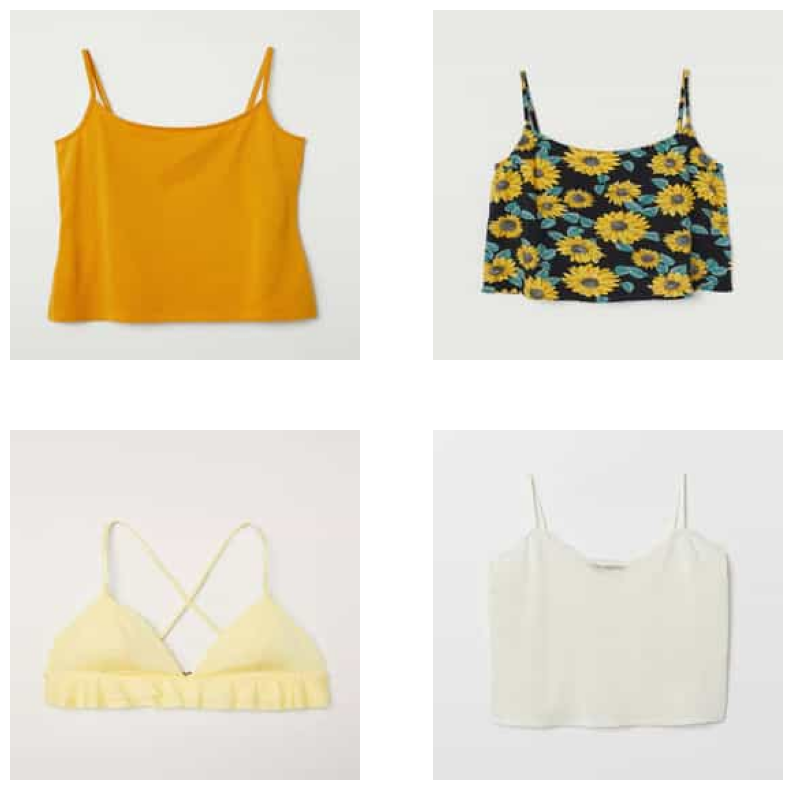

In [123]:
find_matches(model, 
             image_emebddings,
             query_input="yellow strap top",
             image_filenames=valid_dataframe['image'].values,
             max_out=4)

## Image to Text Matches

In [238]:
def get_text_embeddings(valid_df,model_path):
    tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
    full_dataframe,full_data_loader = build_loader(dataframe,tokenizer,mode='valid')
    model = CLIPModel().to('cuda')
    model.load_state_dict(torch.load(model_path,map_location='cuda'))
    model.eval()
    
    valid_text_embeddings=[]
    with torch.no_grad():
        for batch in tqdm(full_data_loader):
            input_ids,attention_mask = batch['input_ids'].to('cuda'),batch['attention_mask'].to('cuda')
            text_features = model.text_encoder(input_ids=input_ids,attention_mask=attention_mask)
            text_embeddings = model.text_projection(text_features)
            valid_text_embeddings.append(text_embeddings)
        
    return model, torch.cat(valid_text_embeddings)

model, text_emebddings = get_text_embeddings(valid_dataframe,model_path ="/kaggle/working/best.pt")

  0%|          | 0/3285 [00:00<?, ?it/s]

In [239]:
text_emebddings.shape ,image_emebddings.shape

(torch.Size([105100, 256]), torch.Size([10509, 256]))

In [240]:
def find_text_matches(model, text_emebddings, image_path,actual_captions,max_out=4):
    item={}
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    transform = A.Compose([
                        A.Resize(224,224,always_apply=True),
                        A.Normalize(max_pixel_value=255.0,always_apply=True)
                            ])
    trans_image = transform(image=image)['image']
    item['image'] = torch.tensor(trans_image).permute(2,0,1).float().unsqueeze(0)
    print("shape of Image ",item['image'].shape)
    
    #Prediction
    with torch.no_grad():
        image_features = model.image_encoder(item['image'].to('cuda'))
        image_embeddings = model.image_projection(image_features)
        image_embeddings_n = F.normalize(image_embeddings,p=2,dim=-1)
        text_embeddings_n = F.normalize(text_emebddings,p=2,dim=-1)
        print("Image_embedding_shape",image_embeddings_n.shape)
        print("Text_embeddings_shape",text_embeddings_n.shape)
        dot_similarity = text_embeddings_n @ image_embeddings_n.T
        print("dot_similarity",dot_similarity.shape)
        print("dot_similarity transpose",dot_similarity.T)
#         values,indices = torch.topk(dot_similarity.T.squeze(0) ,k=20)
        values,indices = torch.topk(dot_similarity.T.cpu() ,k=20)
        matches = [actual_captions[idx] for idx in indices[::5]]
        print(matches)
    
#     return item
    
    

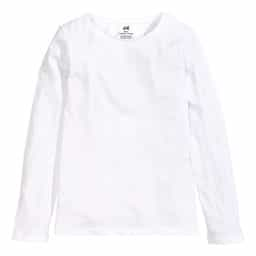

In [243]:
image_path = "/kaggle/input/images-file/new_resized_folder/0163734002.jpg"
import IPython
IPython.display.Image(image_path)

In [244]:
find_text_matches(model,text_emebddings,image_path,dataframe['caption'].values)

shape of Image  torch.Size([1, 3, 224, 224])
Image_embedding_shape torch.Size([1, 256])
Text_embeddings_shape torch.Size([105100, 256])
dot_similarity torch.Size([105100, 1])
dot_similarity transpose tensor([[0.2019, 0.3002, 0.2855,  ..., 0.1836, 0.1473, 0.2911]],
       device='cuda:0')
[array(['White Bronx tieblouse', 'White v 5 The Wolf',
       'White Hamilton Horse story', 'White TRACEY LONG SLEEVE',
       'White Brody long sleeve', 'White Story', 'White Story',
       'White Shenzi LP', 'White Iggy knit',
       'White Sunflower Bell Sleeve', 'White Peppermint sweater',
       'White CSP Fabrizia', 'White NOIR pima pique l sleeve',
       'White TESS LONG SLEEVE', 'White Paulie',
       'White Porto long sleeve', 'White Terminator',
       'White Eucalyptus CF', 'White Eucalyptus CF', 'White Ghost LS'],
      dtype=object)]


In [245]:
dataframe[dataframe['article_id']==163734002]

,article_id,caption,image,id
81,163734002,Black KOMPIS 2 pack L S,0163734002.jpg,81
